In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg

# Spark Session
spark = SparkSession.builder \
    .appName("Geizhals-Steam-Static-Join") \
    .master("local[*]") \
    .getOrCreate()

# Parquet-Daten einlesen
gpu_static = spark.read.parquet("/tmp/gpu_data")
ram_static = spark.read.parquet("/tmp/ram_data")
ssd_static = spark.read.parquet("/tmp/ssd_data")
cpu_static = spark.read.parquet("/tmp/cpu_data")
steam_static = spark.read.parquet("/tmp/steam_data")



In [30]:
from pyspark.sql.functions import avg, regexp_extract, col
from pyspark.sql import Row

# --- GPU Matching ---
gpu_common = steam_static.filter(col("category") == "Video Card Description") \
    .select("most_common").limit(1).collect()[0]["most_common"]

# Extrahiere "RTX xxxx" oder "RX xxxx" (z.B. RTX 4080 oder RX 7800)
import re
gpu_tag_match = re.search(r"(RTX \d{4}|RX \d{4})", gpu_common)
if gpu_tag_match:
    gpu_tag = gpu_tag_match.group(1)
    gpu_filtered = gpu_static.filter(col("Produktname").contains(gpu_tag))
    gpu_avg = gpu_filtered.agg(avg("Preis_EUR")).collect()[0][0]
else:
    gpu_avg = None

# --- SSD Matching ---
ssd_common = steam_static.filter(col("category") == "Total Hard Drive Space") \
    .select("most_common").limit(1).collect()[0]["most_common"]

ssd_numeric = ssd_static.withColumn("Speicher_num", regexp_extract("Speicher", r"(\d+(?:\.\d+)?)", 1).cast("float"))
if "Above 1 TB" in ssd_common:
    ssd_filtered = ssd_numeric.filter(col("Speicher_num") > 1.0)
    ssd_avg = ssd_filtered.agg(avg("Preis_EUR")).collect()[0][0]
else:
    ssd_avg = None

# --- CPU Matching ---
cpu_common = steam_static.filter(col("category") == "Intel CPU Speeds") \
    .select("most_common").limit(1).collect()[0]["most_common"]

cpu_range_match = re.search(r"(\d+\.\d+)\s*Ghz to (\d+\.\d+)\s*Ghz", cpu_common)
if cpu_range_match:
    min_ghz = float(cpu_range_match.group(1))
    max_ghz = float(cpu_range_match.group(2))
    cpu_filtered = cpu_static.filter((col("Basistakt_GHz") >= min_ghz) & (col("Basistakt_GHz") <= max_ghz))
    cpu_avg = cpu_filtered.agg(avg("Price_EUR")).collect()[0][0]
else:
    cpu_avg = None

# RAM
ram_common = steam_static.filter(col("category") == "System RAM") \
    .select("most_common").limit(1).collect()[0]["most_common"].replace(" ", "")
ram_avg = ram_static.withColumn("Kapazitaet_clean", regexp_replace("Kapazitaet", " ", "")) \
    .filter(col("Kapazitaet_clean") == ram_common) \
    .agg(avg("Preis_EUR")).collect()[0][0]


# VRAM
vram_common = steam_static.filter(col("category") == "VRAM") \
    .select("most_common").limit(1).collect()[0]["most_common"].replace(" ", "")
vram_avg = gpu_static.withColumn("VRAM_clean", regexp_replace("VRAM", " ", "")) \
    .filter(col("VRAM_clean") == vram_common) \
    .agg(avg("Preis_EUR")).collect()[0][0]


# Zusammenfassen in DataFrame

summary_rows = [
    Row(komponente="RAM", common=ram_common, preis=round(ram_avg, 2) if ram_avg else None),
    Row(komponente="VRAM", common=vram_common, preis=round(vram_avg, 2) if vram_avg else None),
    Row(komponente="GPU", common=gpu_common, preis=round(gpu_avg, 2) if gpu_avg else None),
    Row(komponente="SSD", common=ssd_common, preis=round(ssd_avg, 2) if ssd_avg else None),
    Row(komponente="CPU", common=cpu_common, preis=round(cpu_avg, 2) if cpu_avg else None),
]
summary_df = spark.createDataFrame(summary_rows)
summary_df.show(truncate=False)


+----------+-----------------------+------+
|komponente|common                 |preis |
+----------+-----------------------+------+
|RAM       |16GB                   |46.02 |
|VRAM      |8GB                    |418.88|
|GPU       |NVIDIA GeForce RTX 3060|565.22|
|SSD       |Above 1 TB             |336.25|
|CPU       |2.3 Ghz to 2.69 Ghz    |176.03|
+----------+-----------------------+------+



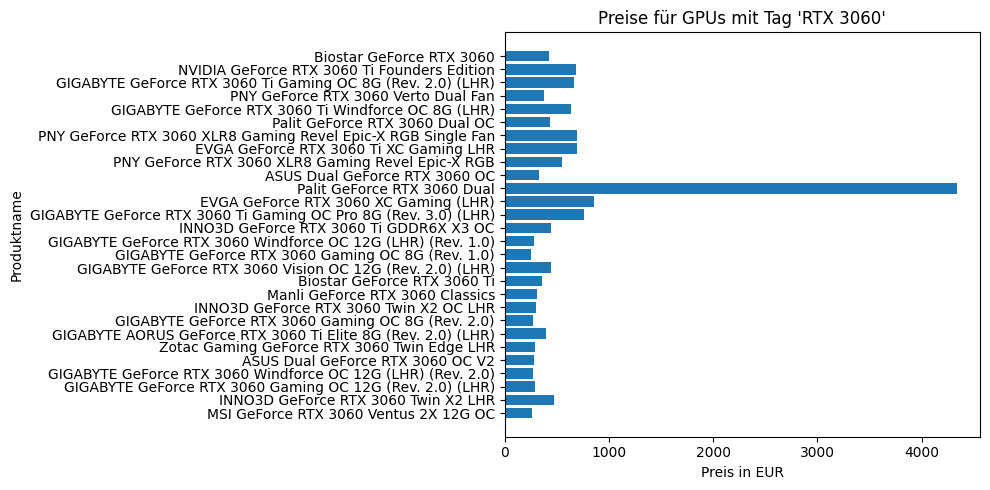

In [31]:
import matplotlib.pyplot as plt


if gpu_tag_match:
    gpu_tag = gpu_tag_match.group(1)
    gpu_filtered = gpu_static.filter(col("Produktname").contains(gpu_tag))

    # Lokale Kopie als Pandas-DataFrame zum Plotten
    gpu_pd = gpu_filtered.select("Produktname", "Preis_EUR").toPandas()

    # Plot erstellen
    plt.figure(figsize=(10, 5))
    plt.barh(gpu_pd["Produktname"], gpu_pd["Preis_EUR"])
    plt.title(f"Preise für GPUs mit Tag '{gpu_tag}'")
    plt.xlabel("Preis in EUR")
    plt.ylabel("Produktname")
    plt.tight_layout()
    plt.show()
else:
    print("Kein gültiger GPU-Tag gefunden, kein Plot möglich.")

## ja ich hab nachgeschaut in Geizhals der Palit 3060 wird mit 4000 EUR gelistet


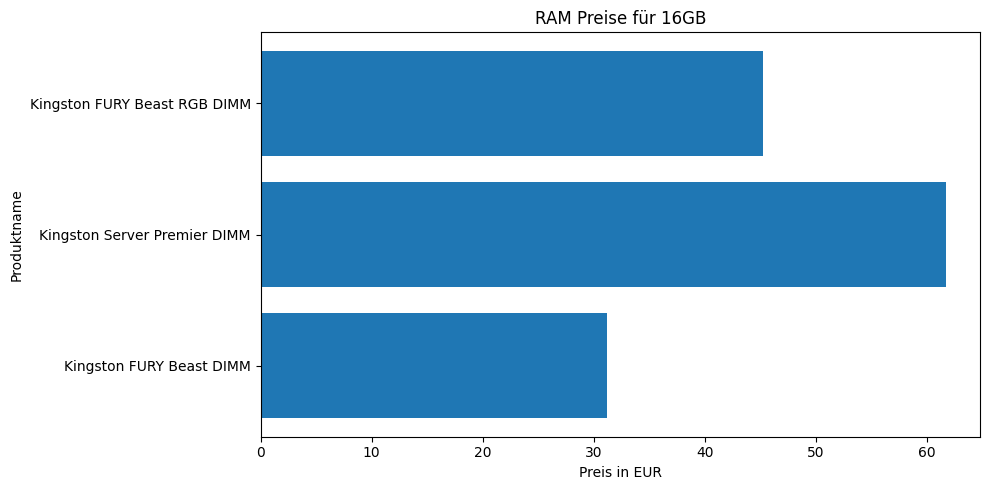

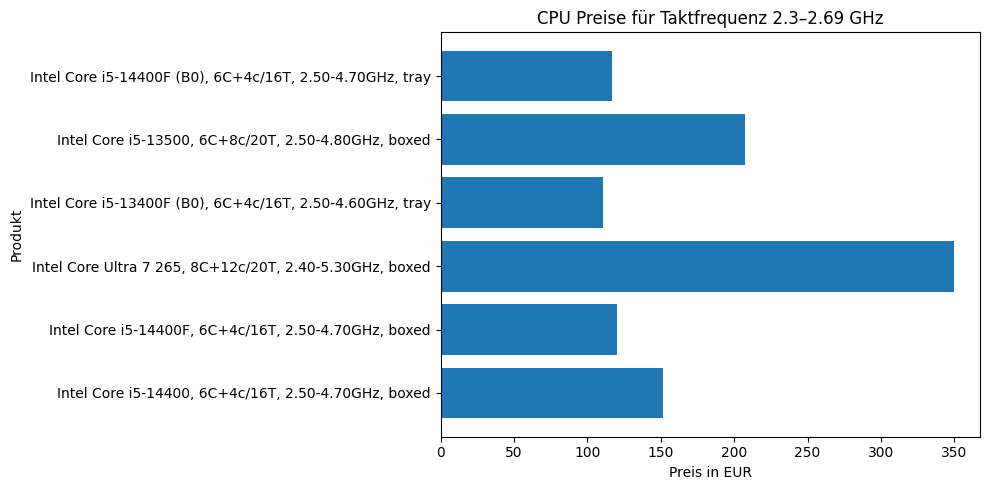

In [32]:
import matplotlib.pyplot as plt

# RAM plot
ram_pd = ram_static.withColumn("Kapazitaet_clean", regexp_replace("Kapazitaet", " ", "")) \
    .filter(col("Kapazitaet_clean") == ram_common) \
    .select("Produktname", "Preis_EUR") \
    .toPandas()

plt.figure(figsize=(10, 5))
plt.barh(ram_pd["Produktname"], ram_pd["Preis_EUR"])
plt.title(f"RAM Preise für {ram_common}")
plt.xlabel("Preis in EUR")
plt.ylabel("Produktname")
plt.tight_layout()
plt.show()


# CPU plot
if cpu_range_match:
    cpu_filtered_plot = cpu_static.filter((col("Basistakt_GHz") >= min_ghz) & (col("Basistakt_GHz") <= max_ghz))
    cpu_pd = cpu_filtered_plot.select("Title", "Price_EUR").toPandas()

    plt.figure(figsize=(10, 5))
    plt.barh(cpu_pd["Title"], cpu_pd["Price_EUR"])
    plt.title(f"CPU Preise für Taktfrequenz {min_ghz}–{max_ghz} GHz")
    plt.xlabel("Preis in EUR")
    plt.ylabel("Produkt")
    plt.tight_layout()
    plt.show()
else:
    print("CPU Range konnte nicht erkannt werden.")


In [18]:
# Ergebnis-Daten als Parquet speichern
summary_df.write.mode("overwrite").parquet("/tmp/summary_preise")



In [19]:
# Später aufrufen mit:
summary_loaded = spark.read.parquet("/tmp/summary_preise")
summary_loaded.show()


+----------+--------------------+------+
|komponente|              common| preis|
+----------+--------------------+------+
|       GPU|NVIDIA GeForce RT...|565.22|
|       SSD|          Above 1 TB|336.25|
|       CPU| 2.3 Ghz to 2.69 Ghz|176.03|
|      VRAM|                 8GB|418.88|
|       RAM|                16GB| 46.02|
+----------+--------------------+------+



In [21]:
from pyspark.sql.functions import col

# Daten vorbereiten (falls nicht schon)
summary_df.createOrReplaceTempView("komponenten_preise")

# RAM, CPU, SSD summieren
fixed_sum = summary_df.filter(col("komponente").isin("RAM", "CPU", "SSD")) \
                      .agg({"preis": "sum"}) \
                      .collect()[0][0]

# GPU + VRAM Mittelwert bilden
gpu_vram_avg = summary_df.filter(col("komponente").isin("GPU", "VRAM")) \
                         .agg({"preis": "avg"}) \
                         .collect()[0][0]

# Endgültige Gesamtsumme
gesamtpreis = fixed_sum + gpu_vram_avg

print(f"Durchschnittlicher Gesamtpreis für Gaming Komponenten (GPU, CPU, SSD, RAM): {gesamtpreis:.2f} EUR")


Durchschnittlicher Gesamtpreis für Gaming Komponenten (GPU, CPU, SSD, RAM): 1050.35 EUR
